In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import shap

In [2]:
pitches = pd.read_csv("2024pitches.csv")
pitch_clusters = pd.read_csv("pitch_clusters.csv")
pd.set_option('display.max_columns', None)
pitches.head()

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,0,1669,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,single,hit_into_play,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,X,1.0,ground_ball,1,0,2024,NaN,NaN,NaN,NaN,682983.0,642021.0,NaN,2,9,Bot,118.13,186.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,75,2,NaN,4,4,4,4,4,5,5,4,NaN,NaN,NaN,0.370,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.630,0.630,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1736,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,B,NaN,NaN,0,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,642021.0,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,1,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,-0.005,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.635,0.635,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1880,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,walk,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,3,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.7,NaN,0.0,0.0,NaN,74,4,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.007,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2002,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,2,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,3,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2156,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,1,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,2,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628

In [3]:
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone",
    "des", "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b",
    "on_2b", "on_1b", "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc",
    "launch_speed", "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle"]

pitch_data = pitches[columns]
pitch_data = pitch_data.dropna(subset=['pitch_type', 'release_speed', 'spin_axis', 'release_extension', 'effective_speed'])

#reshape the cluster data to long format and merge with pitch data
pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = pitch_data.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')

#create zone features using the plate_x and plate_z features
x_bins = np.linspace(-2, 2, num=5)  
z_bins = np.linspace(0, 4, num=5)   
pitch_data["zone_x"] = np.digitize(pitch_data["plate_x"], bins=x_bins, right=False)
pitch_data["zone_z"] = np.digitize(pitch_data["plate_z"], bins=z_bins, right=False)
pitch_data["zone"] = pitch_data["zone_x"].astype(str) + "-" + pitch_data["zone_z"].astype(str)

#we want to create hitter zone and pitch type success features using KNN
pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()
features = ["launch_angle", "launch_speed"]
target = "estimated_woba_using_speedangle"
pitch_data_bip = pitch_data_bip.dropna(subset=features + [target])

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitch_data_bip[features])

#train KNN to estimate hitter performance based on launch angle and exit velocity

knn = KNeighborsRegressor(n_neighbors=10, weights="distance")
knn.fit(X_scaled, pitch_data_bip[target])

pitch_data_bip["xwOBA_KNN"] = knn.predict(X_scaled)  #apply predictions back to the dataset

#calculate average predicted expected wOBA per zone and pitch type for hitters
zone_success = pitch_data_bip.groupby(["batter", "zone_x", "zone_z"])["xwOBA_KNN"].mean().reset_index()
pitch_type_success = pitch_data_bip.groupby(["batter", "pitch_type"])[target].mean().reset_index()
pitch_type_success.rename(columns={target: "estimated_woba_by_pitch_type"}, inplace=True)
pitcher_zone_xwoba = pitch_data_bip.groupby(["pitcher", "zone_x", "zone_z"])[target].mean().reset_index()
pitcher_zone_xwoba.rename(columns={target: "pitcher_zone_xwoba_allowed"}, inplace=True)

pitch_data = pitch_data.drop(columns=["estimated_woba_using_speedangle_zone_avg"], errors="ignore")
#merge new metrics back into dataset
pitch_data = pitch_data.merge(zone_success, on=["batter", "zone_x", "zone_z"], how="left")
pitch_data = pitch_data.merge(pitch_type_success, on=["batter", "pitch_type"], how="left")
pitch_data = pitch_data.merge(pitcher_zone_xwoba, on=["pitcher", "zone_x", "zone_z"], how="left")
pitch_data.rename(columns={"xwOBA_KNN": "estimated_woba_using_speedangle_zone_avg"}, inplace=True)


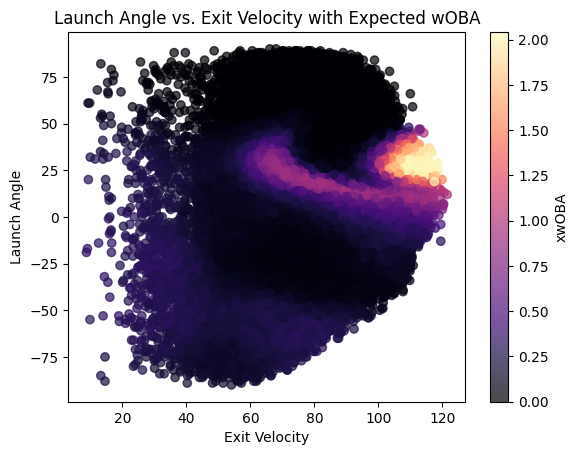

In [48]:
#plot to help visualize the K-Nearest Neighbors
pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()
pitch_data_bip = pitch_data_bip.dropna(subset=["launch_angle", "launch_speed"])
plt.scatter(pitch_data_bip["launch_speed"], pitch_data_bip["launch_angle"], 
            c=pitch_data_bip["estimated_woba_using_speedangle"], cmap="magma", alpha=0.7)
plt.colorbar(label="xwOBA")
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.title("Launch Angle vs. Exit Velocity with Expected wOBA")
plt.show()

In [6]:
pitch_data.sample(10)

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,hc_x,hc_y,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_woba_using_speedangle,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,bat_win_exp,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,arm_angle,cluster_label,zone_x,zone_z,estimated_woba_using_speedangle_zone_avg,estimated_woba_by_pitch_type,pitcher_zone_xwoba_allowed
645900,CU,75.6,0.90,6.10,669397,664285,NaN,foul,3-2,"Nick Allen grounds out, shortstop Jeremy Peña ...",R,R,L,S,2,1,-1.18,-1.11,0.00,1.92,NaN,NaN,NaN,NaN,NaN,NaN,0.206424,-110.068505,0.436545,-9.520306,22.520100,-41.420233,3.07,1.41,3.0,78.0,-33.0,74.5,2805.0,5.8,746337,54.68,NaN,NaN,36,4,Curveball,2,0,322.0,0.000,-0.049,62.0,7.0,NaN,0.049,0.211,2,1,42.0,1.0,3,2,0.287524,0.536000,0.271370
485233,FC,89.7,-2.49,5.76,642020,608723,NaN,swinging_strike,3-2,Chuckie Robinson reaches on a fielding error b...,R,R,R,S,1,0,0.38,0.37,0.96,1.51,NaN,681460.0,NaN,NaN,NaN,NaN,7.744044,-130.415326,-5.315710,2.681272,27.391382,-27.057330,3.56,1.67,NaN,NaN,NaN,89.9,2370.0,6.5,746768,54.05,NaN,NaN,58,2,Cutter,1,5,166.0,0.000,-0.048,74.0,8.0,NaN,0.048,0.073,1,2,39.0,0.0,3,2,0.175079,0.233200,0.320500
667606,SI,89.1,2.91,5.42,683002,674944,NaN,ball,2-2,"Gunnar Henderson grounds into a force out, sec...",R,L,L,B,1,1,1.11,0.24,-0.11,1.25,NaN,NaN,656896.0,NaN,NaN,NaN,-9.767752,-129.346221,-4.709674,14.511447,27.095218,-28.649873,3.66,1.71,NaN,NaN,NaN,89.2,2068.0,6.5,746422,53.99,NaN,NaN,32,3,Sinker,0,1,128.0,0.000,0.042,NaN,NaN,NaN,-0.042,0.618,1,2,41.0,2.0,2,2,0.268830,0.375063,0.231100
320749,FF,95.0,-2.35,5.56,666163,450203,NaN,ball,2-5,Ben Rortvedt strikes out swinging.,R,L,R,B,2,2,-0.80,0.79,-0.73,4.54,NaN,NaN,NaN,NaN,NaN,NaN,6.009070,-138.363142,1.133649,-11.501031,26.537924,-22.323482,3.21,1.46,NaN,NaN,NaN,95.2,2192.0,6.1,747113,54.44,NaN,NaN,11,6,4-Seam Fastball,0,1,241.0,0.000,0.041,NaN,NaN,NaN,-0.041,0.573,1,0,22.0,0.0,2,5,NaN,0.290104,NaN
677662,FF,96.3,-1.54,5.79,680869,596133,NaN,foul,3-4,Zack Gelof strikes out swinging.,R,R,R,S,0,1,-0.60,1.76,0.27,3.41,NaN,NaN,668709.0,NaN,NaN,NaN,6.137449,-140.000235,-4.636747,-9.406465,35.896644,-8.231131,3.38,1.56,4.0,74.8,-42.0,95.2,2589.0,6.0,745606,54.50,NaN,NaN,71,2,4-Seam Fastball,2,4,204.0,0.000,-0.046,76.0,7.0,NaN,0.046,0.044,1,3,48.0,0.0,3,4,0.660583,0.465295,0.324724
78465,FF,93.3,2.70,5.98,542303,677053,NaN,ball,3-4,Marcell Ozuna singles on a sharp line drive to...,R,R,L,B,0,0,0.64,1.41,0.13,3.88,660670.0,645277.0,621566.0,NaN,NaN,NaN,-8.031026,-135.600997,-2.741619,9.616624,29.984210,-14.331523,3.53,1.72,NaN,NaN,NaN,93.5,2131.0,6.5,746084,54.02,NaN,NaN,53,1,4-Seam Fastball,0,3,152.0,0.000,0.089,NaN,NaN,NaN,-0.089,0.909,1,3,51.0,2.0,3,4,0.580644,0.512480,0.366833
628435,FC,89.0,1.26,5.79,571448,641482,NaN,foul,2-2,Nolan Arenado lines out to left fielder Alex V...,R,R,L,S,0,0,-0.16,1.08,-0.55,1.99,NaN,NaN,NaN,NaN,NaN,NaN,-4.063180,-129.668079,-5.589429,-1.102881,23.886933,-18.996943,3.38,1.64,10.0,93.0,-11.0,88.7,2340.0,5.7,745701,54.75,NaN,NaN,32,1,Cutter,2,5,169.0,0.000,-0.016,74.0,8.0,NaN,0.016,0.803,3,2,55.0,1.0,2,2,0.353049,0.315303,0.468306
209869,CH,84.9,-1.70,5.31,665742,541640,NaN,ball,3-1,"Juan Soto grounds out, shortstop Amed Rosario ...",R,L,R,B,1,2,-1.20,0.63,0.12,0.18,NaN,NaN,NaN,NaN,NaN,NaN,6.685143,-123.396373,-6.920781,-13.616928,24.950694,-24.506036,2.91,1.44,NaN,NaN,NaN,85.0,1601.0,6.5,745092,54.01,NaN,NaN,74,4,Changeup,5,10,225.0,0.000,0.036,NaN,NaN,NaN,-0.036,0.995,1,4,36.0,NaN,3,1,NaN,0.386426,NaN
299107,ST,76.6,-1.98,5.74,664238,683155,field_out,hit_into_play,3-3,Dylan Moore flies out to left fielder 

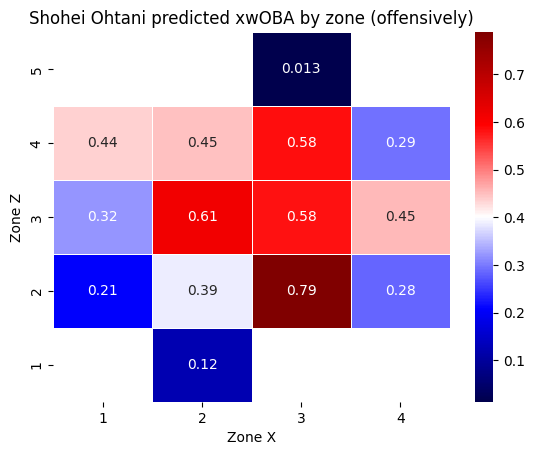

In [28]:
#For an example, here are the expected wOBA predictions by zone for Shohei Ohtani given his launch angle and exit velocity data

ohtani_data = pitch_data[pitch_data["batter"] == 660271]
pivot_table = ohtani_data.pivot_table(
    values="estimated_woba_using_speedangle_zone_avg",
    index="zone_z",
    columns="zone_x",
    aggfunc="mean")   #avg wOBA for each zone

sns.heatmap(pivot_table, annot=True, cbar=True, cmap="seismic", linewidths=0.5)
plt.xlabel("Zone X")
plt.ylabel("Zone Z")
plt.title("Shohei Ohtani predicted xwOBA by zone (offensively)")
plt.gca().invert_yaxis()  
plt.show()

/var/folders/94/3wrvjhfs4nd37ndfjnzsbh600000gn/T/ipykernel_32593/3204889603.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="estimated_woba_by_pitch_type", y="pitch_type", data=pitch_type_xwoba, palette="magma", edgecolor="black")


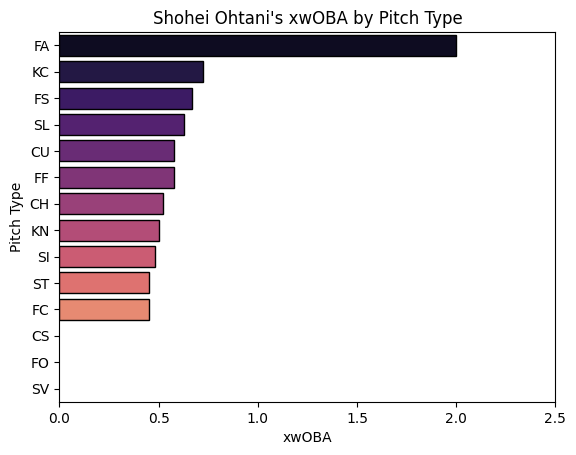

In [30]:
#goes off figure above that looks at estimated wOBA by zone, this looks at it by pitch type

pitch_type_xwoba = ohtani_data.groupby("pitch_type")["estimated_woba_by_pitch_type"].mean().reset_index()
pitch_type_xwoba = pitch_type_xwoba.sort_values(by="estimated_woba_by_pitch_type", ascending=False)
sns.barplot(x="estimated_woba_by_pitch_type", y="pitch_type", data=pitch_type_xwoba, palette="magma", edgecolor="black")
plt.xlabel("xwOBA")
plt.ylabel("Pitch Type")
plt.title("Shohei Ohtani's xwOBA by Pitch Type")
plt.xlim(0, 2.5) 
plt.show()

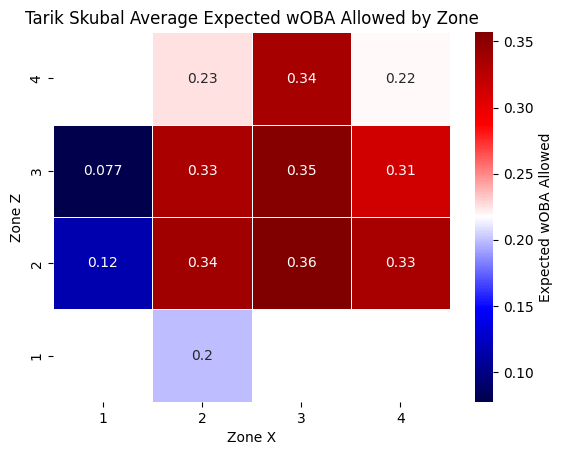

In [31]:
#Similar to Ohtani offensive success by zone plot, but this is an example for a given pitcher (Tarik Skubal in this case)

skubal_profile = pitcher_zone_xwoba[pitcher_zone_xwoba["pitcher"] == 669373]
pivot = skubal_profile.pivot(index="zone_z", columns="zone_x", values="pitcher_zone_xwoba_allowed")
sns.heatmap(pivot, annot=True, cmap="seismic", linewidths=0.5, cbar_kws={"label": "Expected wOBA Allowed"})
plt.xlabel("Zone X")
plt.ylabel("Zone Z")
plt.title("Tarik Skubal Average Expected wOBA Allowed by Zone")
plt.gca().invert_yaxis()
plt.show()

In [10]:
#filter to only pitches put into play
pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"]

#features for model training
features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'estimated_woba_by_pitch_type', 
            'cluster_label', 'n_thruorder_pitcher', 'balls', 'strikes']

target = 'estimated_woba_using_speedangle'
pitch_data_clean = pitch_data_bip.dropna(subset=[target, 'balls', 'strikes'])
pitch_data_encoded = pd.get_dummies(pitch_data_clean, columns=['pitch_type']) #one hot encode pitch type column
features = [col for col in features if col in pitch_data_encoded.columns]  #only include features existing in encoded dataframe

X_train, X_test, y_train, y_test = train_test_split(pitch_data_encoded[features], 
                                                    pitch_data_encoded[target], test_size=0.2, random_state=4400)

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=4400)

param_grid = {'max_depth': [2, 4, 6, 8],   
              'learning_rate': [0.05, 0.1, 0.2],
              'n_estimators': [100, 200, 300],
              'subsample': [0.85, 0.9, 0.95],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'reg_lambda': [0.1, 1, 10],          
              'reg_alpha': [0.1, 1, 10]}

#tune hyperparameters with 3-fold cross-validation
grid_search = GridSearchCV(xgb_regressor, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best XGBoost Params: {best_params}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

#cross-validation performance on the train set
cv_scores = cross_val_score(best_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
print(f"CV RMSE: {-cv_scores.mean()} ± {cv_scores.std()}")


Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 10, 'reg_lambda': 0.1, 'subsample': 0.9}
RMSE: 0.36271656830976895
MAE: 0.2733370381998986
R² Score: 0.11143410399755393
CV RMSE: 0.36368763824266287 ± 0.0009378066118083065


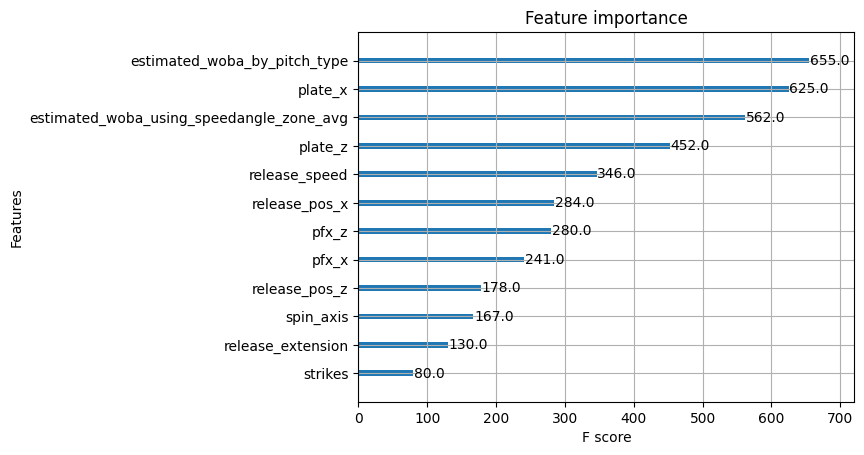

In [50]:
xgb.plot_importance(best_model, importance_type='weight', max_num_features=12)
plt.show()

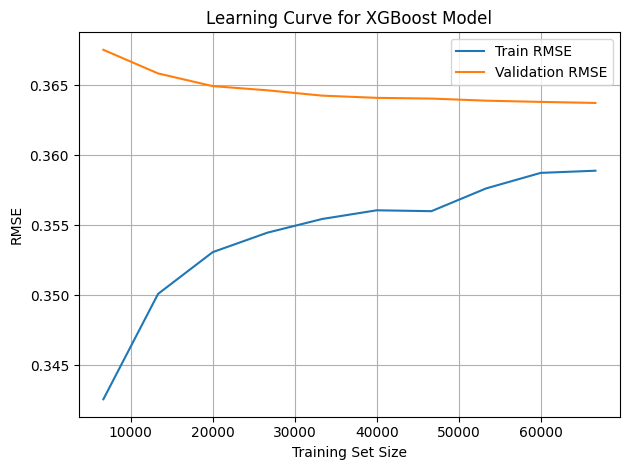

In [68]:
#compare the learning curves of the train and validation sets

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_root_mean_squared_error',
    cv=3)

train_errors = -np.mean(train_scores, axis=1)
val_errors = -np.mean(val_scores, axis=1)
plt.plot(train_sizes, train_errors, label='Train RMSE')
plt.plot(train_sizes, val_errors, label='Validation RMSE')
plt.title('Learning Curve for XGBoost Model')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

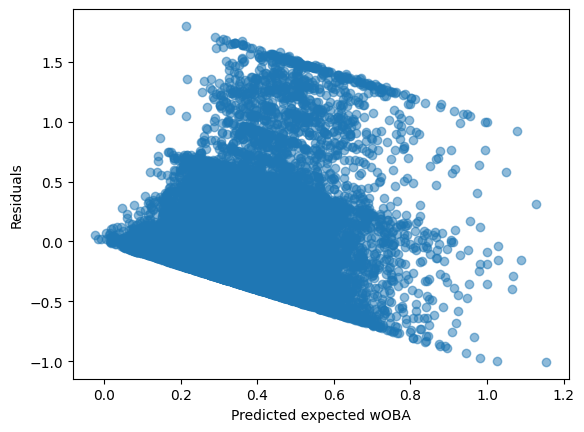

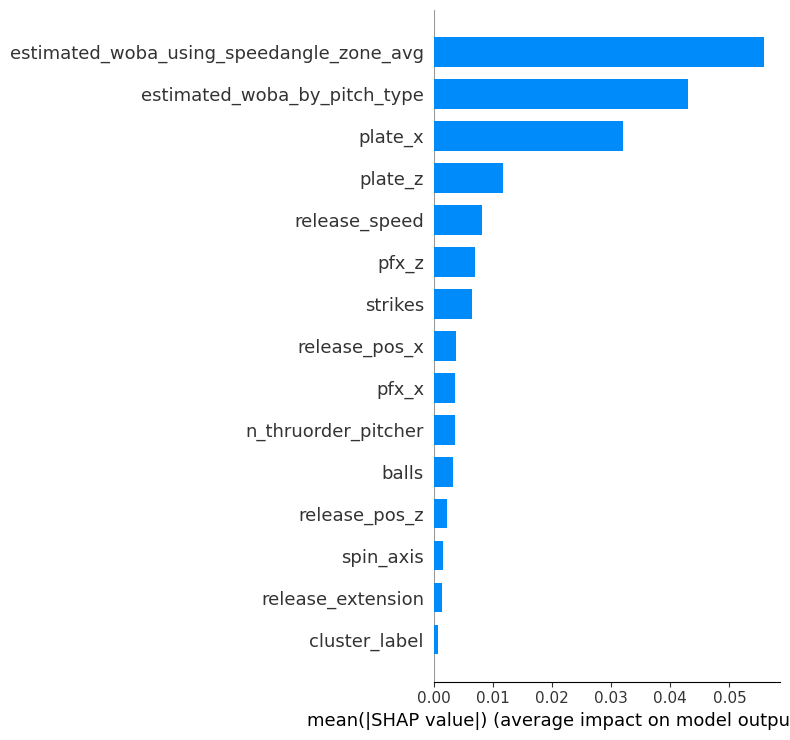

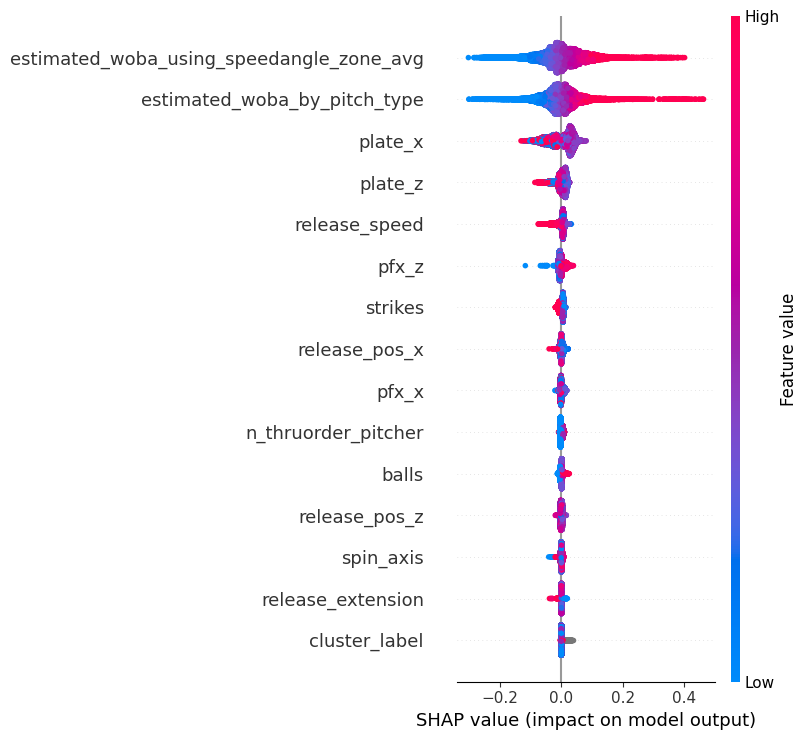

10 biggest prediction errors:
        release_speed  release_pos_x  release_pos_z  pfx_x  pfx_z  plate_x  \
310919           96.0          -0.83           5.80  -0.43   1.42    -0.72   
484455           83.0          -0.54           5.98   0.57  -0.91     0.20   
188133           94.1           1.33           6.02   1.02   1.52     0.79   
671709           91.0          -0.76           5.95  -0.90   0.79    -0.88   
18171            90.1           1.02           5.90   0.21   1.69    -0.87   
737633           96.9           1.69           6.41   0.62   1.44     0.34   
17331            82.2           1.59           5.60   1.55   0.59    -0.78   
424176           90.2          -1.49           5.27  -0.19   1.09     0.10   
582578           94.0          -2.01           5.78  -0.49   0.99     0.44   
30478            91.8           2.26           6.02  -0.13   1.00    -0.69   

        plate_z  spin_axis  release_extension  \
310919     3.61      209.0                7.7   
484455     2.

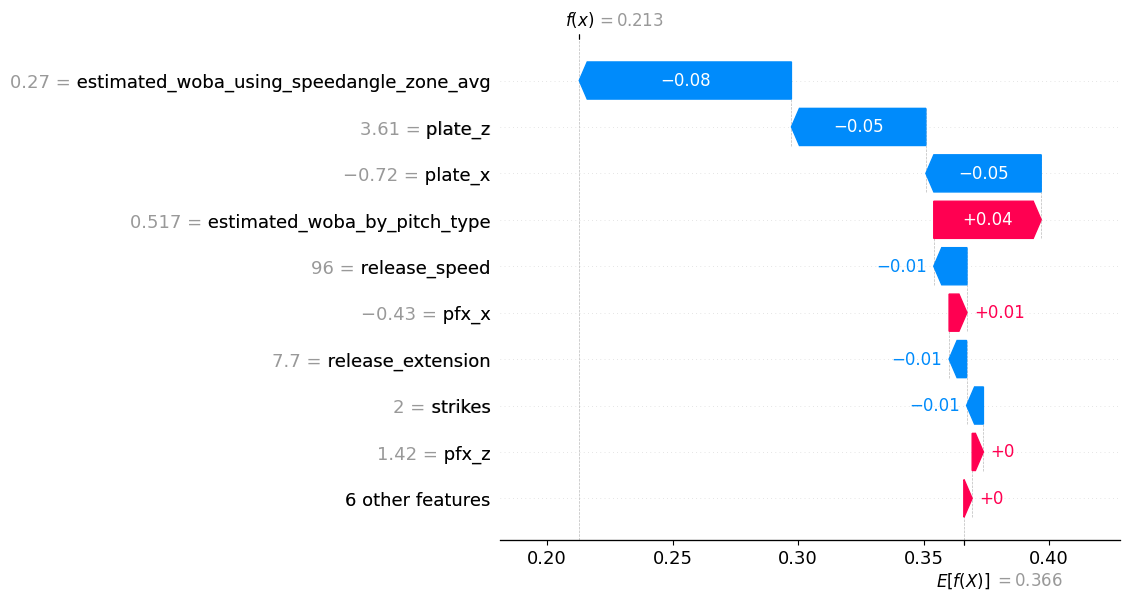

In [32]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)  #plot the predicted xwOBA vs residuals 
#wOBA will have a min value of 0 
plt.xlabel("Predicted expected wOBA")
plt.ylabel("Residuals")
plt.show()

#compute the SHAP values for the test set and show average absolute SHAP value of each feature
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

#store actuals, predictions, and errors to show where the model was the most wrong
#biggest error should typically happen with a weak hitter hitting a home run against a great pitcher
error_df = X_test.copy()
error_df["actual"] = y_test
error_df["predicted"] = y_pred
error_df["error"] = abs(error_df["actual"] - error_df["predicted"])
print("10 biggest prediction errors:")
print(error_df.sort_values("error", ascending=False).head(10))

#create waterfall plot to see the contribution of each feature to model's output
worst_index = np.argmax(np.abs(y_test - y_pred))
example = X_test.iloc[[worst_index]]
explainer = shap.Explainer(best_model)
shap_values_single = explainer(example)
shap.plots.waterfall(shap_values_single[0], max_display=10)

#positive vals push predictions up, and negative vals push it down

/var/folders/94/3wrvjhfs4nd37ndfjnzsbh600000gn/T/ipykernel_32593/910023395.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_contrib.values, y=mean_contrib.index, palette="magma")


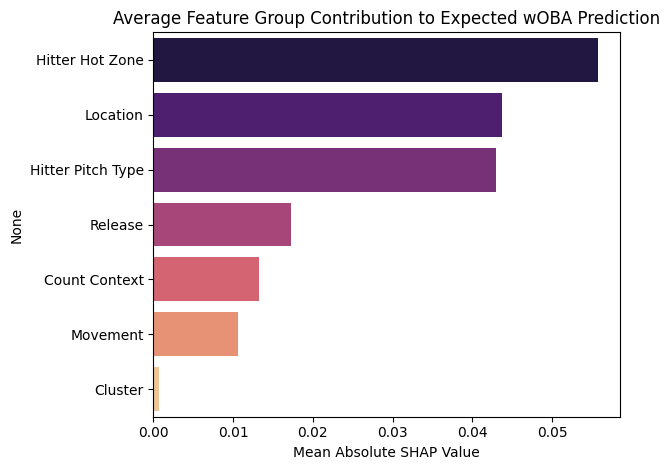

In [36]:
#group related features to see a more aggregated importance plot

feature_groups = {
    "Release": ["release_speed", "release_pos_x", "release_pos_z", "release_extension", "spin_axis"],
    "Movement": ["pfx_x", "pfx_z"],
    "Location": ["plate_x", "plate_z"],
    "Count Context": ["balls", "strikes", "n_thruorder_pitcher"],
    "Hitter Hot Zone": ["estimated_woba_using_speedangle_zone_avg"],
    "Hitter Pitch Type": ["estimated_woba_by_pitch_type"],
    "Cluster": ["cluster_label"]}

#get SHAP values for each feature group
group_shap_values = {}
shap_vals = shap_values.values
feature_names = X_test.columns

#loop through each group and sum the SHAP values across the group
for group_name, group_features in feature_groups.items():
    indices = [i for i, name in enumerate(feature_names) if name in group_features]
    group_shap_values[group_name] = np.abs(shap_vals[:, indices]).sum(axis=1)

#each column is the group and each row is a sample's total SHAP contribution for that group
group_shap_df = pd.DataFrame(group_shap_values)
mean_contrib = group_shap_df.mean().sort_values(ascending=False)
sns.barplot(x=mean_contrib.values, y=mean_contrib.index, palette="magma")
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Average Feature Group Contribution to Expected wOBA Prediction")
plt.tight_layout()
plt.show()

/var/folders/94/3wrvjhfs4nd37ndfjnzsbh600000gn/T/ipykernel_32593/2936188336.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_preds = X_test_copy.groupby(["z_bin", "x_bin"])["predicted_xwoba"].mean().unstack()
/var/folders/94/3wrvjhfs4nd37ndfjnzsbh600000gn/T/ipykernel_32593/2936188336.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zone_counts = X_test_copy.groupby(["z_bin", "x_bin"]).size().unstack()


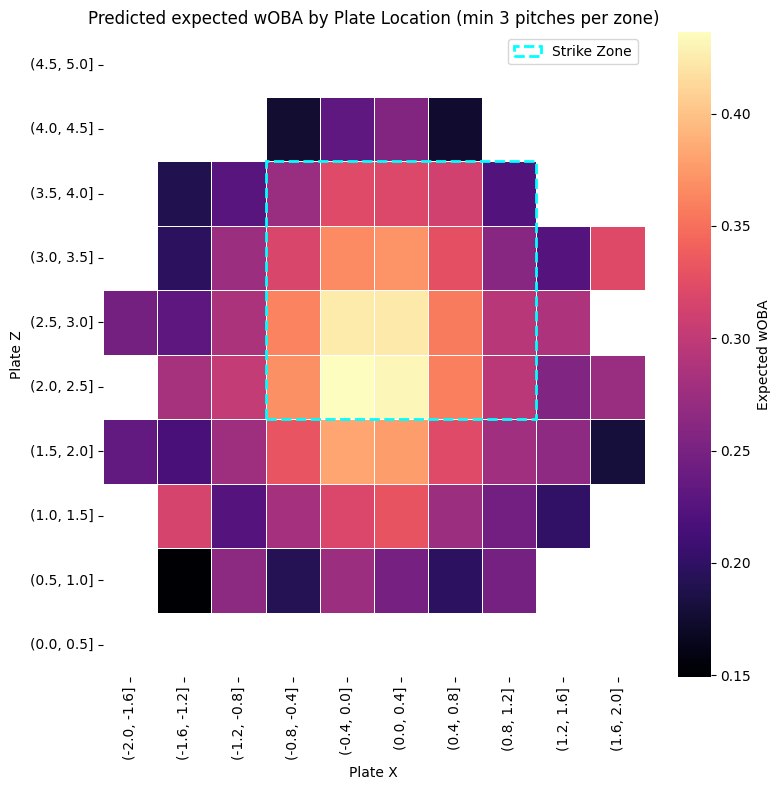

In [51]:
#take a look at the model's overall predictions by zone
x_bins = np.linspace(-2.0, 2.0, num=11)
z_bins = np.linspace(0.0, 5.0, num=11)
X_test_copy["x_bin"] = pd.cut(X_test_copy["plate_x"], bins=x_bins)
X_test_copy["z_bin"] = pd.cut(X_test_copy["plate_z"], bins=z_bins)
#average preidcted wOBA for each zone
zone_preds = X_test_copy.groupby(["z_bin", "x_bin"])["predicted_xwoba"].mean().unstack()
zone_counts = X_test_copy.groupby(["z_bin", "x_bin"]).size().unstack()

#only include zones that had at least three pitches in the test set
min_mask = zone_counts >= 3
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    zone_preds,
    cmap="magma",
    linewidths=0.5,
    cbar_kws={"label": "Expected wOBA"},
    mask=~min_mask)  # mask low-data zones
plt.title("Predicted expected wOBA by Plate Location (min 3 pitches per zone)")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")

#overlay where the strikezone would typically be (plate_z varies a little bit hitter-to-hitter)
strike_x_start = np.digitize([-0.83], x_bins)[0]
strike_x_end   = np.digitize([ 0.83], x_bins)[0]
strike_z_start = np.digitize([ 1.5], z_bins)[0]
strike_z_end   = np.digitize([ 3.5], z_bins)[0]

strike_zone = Rectangle(
    (strike_x_start, strike_z_start),
    width=strike_x_end - strike_x_start,
    height=strike_z_end - strike_z_start,
    linewidth=2,
    edgecolor='cyan',
    facecolor='none',
    linestyle='--',
    label='Strike Zone')
ax.add_patch(strike_zone)
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("predicted xwoba by loc.png", bbox_inches="tight")
plt.show()

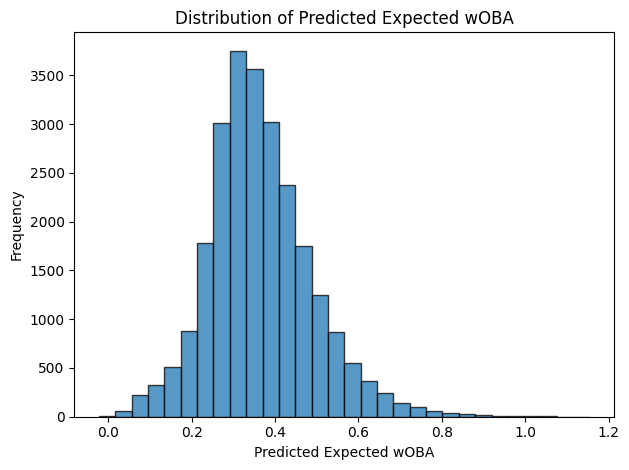

In [66]:
plt.hist(y_pred, bins=30, alpha=0.75, edgecolor="black")
plt.title("Distribution of Predicted Expected wOBA")
plt.xlabel("Predicted Expected wOBA")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

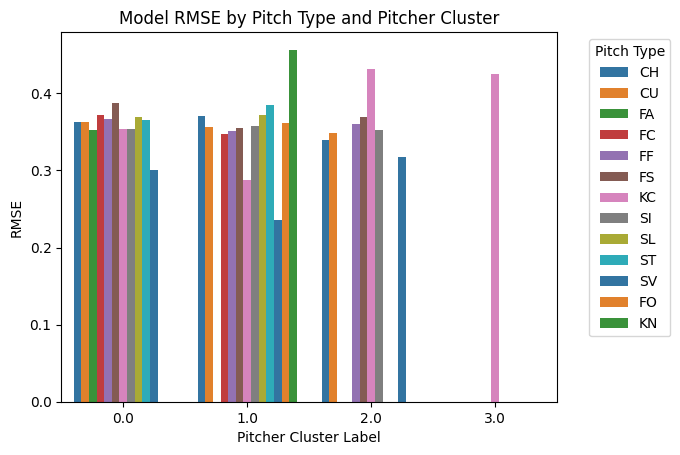

In [46]:
#see performance across clusters for each pitch type

info_cols = pitch_data_clean[["pitch_type", "cluster_label"]].reset_index(drop=True)
X_test_copy = X_test.reset_index(drop=True).copy()
X_test_copy["actual"] = y_test.reset_index(drop=True)  #add actual expected wOBA values to test set
X_test_copy["predicted_xwoba"] = y_pred  #add model predictions to test set

X_test_copy["pitch_type"] = info_cols.loc[X_test_copy.index, "pitch_type"].values   #add pitch type and cluster label back to test data
X_test_copy["cluster_label"] = info_cols.loc[X_test_copy.index, "cluster_label"].values

#group by pitch type and cluster label to see localized performance 
cluster_perf = (X_test_copy.groupby(["pitch_type", "cluster_label"]).apply(lambda df: pd.Series({
        "RMSE": mean_squared_error(df["actual"], df["predicted_xwoba"], squared=False),
        "MAE": mean_absolute_error(df["actual"], df["predicted_xwoba"]),
        "Count": len(df)})).reset_index())

sns.barplot(data=cluster_perf, x="cluster_label", y="RMSE", hue="pitch_type", palette="tab10")
plt.title("Model RMSE by Pitch Type and Pitcher Cluster")
plt.xlabel("Pitcher Cluster Label")
plt.ylabel("RMSE")
plt.legend(title="Pitch Type", bbox_to_anchor=(1.05, 1))
plt.show()


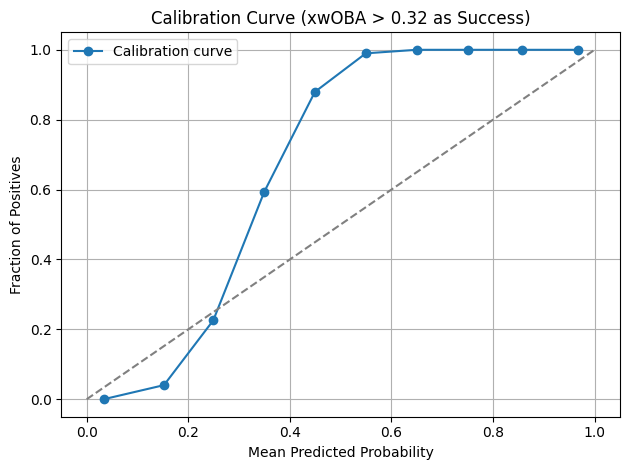

In [75]:
# The MLB average wOBA for a ball put in play is typically around 0.32, so I choose that as a "success threshold"

np.random.seed(4400)
y_true = np.random.uniform(0, 1, 1000)
y_pred = y_true + np.random.normal(0, 0.1, 1000)
y_pred = np.clip(y_pred, 0, 1)

threshold = 0.32
y_binary_true = (y_true > threshold).astype(int)   #success if value is higher than threshold

#calibration curve
prob_true, prob_pred = calibration_curve(y_binary_true, y_pred, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (xwOBA > 0.32 as Success)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()